# PyBERT Viterbi Decoder Testing

Original author: David Banas <capn.freako@gmail.com>  
Original date: June 21, 2025

Copyright &copy; 2025 David Banas; all rights reserved World wide.

## Introduction

Recently, a [Viterbi decoder](https://en.wikipedia.org/wiki/Viterbi_decoder) was added to the _PyBERT_ Rx model, as an alternative to the already existing DFE.
This [Jupyter](https://jupyter.org/) notebook was constructed to exercise the new Viterbi decoder in PyBERT.
Specifically, it is used to compare the performance of that Viterbi decoder to that of the DFE.

## Imports & Helper Functions

In this section we import any required external Python modules and define any needed local helper functions.

In [1]:
%matplotlib inline

from typing import TypeAlias

import numpy        as np
import numpy.typing as npt

from matplotlib    import pyplot as plt
from pybert.pybert import PyBERT

Rvec: TypeAlias = npt.NDArray[np.float64]

# Instantiate and congiure the DUT.
thePyBERT = PyBERT(run_simulation=True, gui=False)
print(thePyBERT.status)
print(thePyBERT.console_log)
cur_log_line = len(thePyBERT.console_log.split("\n"))

def safe_log10(x: Rvec) -> Rvec:
    """
    Take log10 of input argument, guarding against division by zero.
    """
    y = np.where(x == 0, 1e-20 * np.ones(len(x)), x)
    return np.log10(y)


Ready.
PyBERT Console Log

[2025-09-17 16:15:56.964404]: PyBERT: Started.
[2025-09-17 16:15:56.964420]: PyBERT: System: Darwin 23.6.0
[2025-09-17 16:15:56.964424]: PyBERT: Python Version: 3.11.11
[2025-09-17 16:15:56.964426]: PyBERT: PyBERT Version: 8.1.1
[2025-09-17 16:15:56.964428]: PyBERT: PyAMI Version: 7.2.3
[2025-09-17 16:15:56.964430]: PyBERT: PyChOpMarg Version: 3.1.0
[2025-09-17 16:15:56.964432]: PyBERT: GUI Toolkit: qt
[2025-09-17 16:15:56.964435]: PyBERT: Kiva Backend: image



## Performance vs. Loss

In this section we evaluate the performance comparison between Viterbi and DFE as a function of channel loss.

The Tx deemphasis and Rx CTLE peaking have been previously optimized for each channel length used here.
And those optimum equalization settings have been saved to certain PyBERT configuration files, which are used in the code below.

**Note:** The optimizations were performed under the assumption of `N_TAPS` DFE taps available.
(i.e. - The optimization was done in such a way as to favor the DFE in the following comparisons.)


In [2]:
N_TAPS = 4

bit_errs_dfe     = []
bit_errs_viterbi = []
chnl_losses      = []
for cfg_file in ["chnl_1p5.yaml", "chnl_1p75.yaml", "chnl_2p0.yaml", "chnl_2p25.yaml"]:
    thePyBERT.load_configuration(cfg_file)
    thePyBERT.rx_viterbi_symbols = N_TAPS
    thePyBERT.use_agc = False
    thePyBERT.debug   = False
    thePyBERT.rn = 0.01
    thePyBERT.pn = 0.000
    thePyBERT.nbits    = 20_000
    thePyBERT.eye_bits = 10_000
    thePyBERT.rx_use_viterbi = False
    thePyBERT.simulate(initial_run=False)
    bit_errs_dfe.append(thePyBERT.bit_errs)
    thePyBERT.rx_use_viterbi = True
    thePyBERT.simulate(initial_run=False)
    bit_errs_viterbi.append(thePyBERT.bit_errs)
    chnl_losses.append(np.abs(thePyBERT.chnl_H[np.where(thePyBERT.f >= (thePyBERT.bit_rate * 1e9 / 2))[0][0]]))

/Users/dbanas/prj/PyBERT/src/pybert/utility/jitter.py:480: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaus_pdf, centers[pos_tail_ix:-1] * 1e12, hist_dd[pos_tail_ix:-1] * 1e-12)
/Users/dbanas/prj/PyBERT/src/pybert/utility/jitter.py:491: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaus_pdf, centers[1:neg_tail_ix] * 1e12, hist_dd[1:neg_tail_ix] * 1e-12)


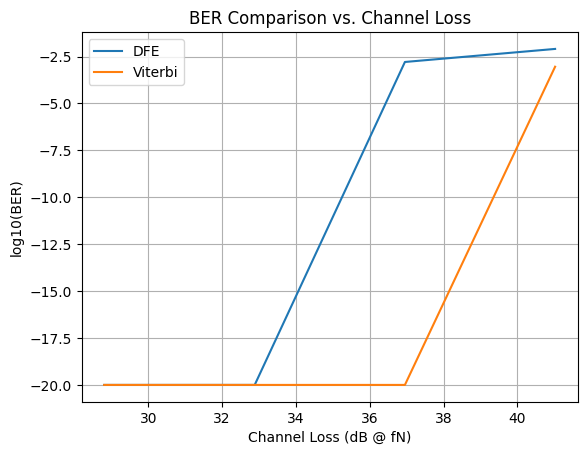

In [3]:
plt.plot(-20 * np.log10(np.array(chnl_losses)),
         safe_log10(np.array(bit_errs_dfe) / 100_000), label="DFE")
plt.plot(-20 * np.log10(np.array(chnl_losses)),
         safe_log10(np.array(bit_errs_viterbi) / 100_000), label="Viterbi")
plt.title("BER Comparison vs. Channel Loss")
plt.xlabel("Channel Loss (dB @ fN)")
plt.ylabel("log10(BER)")
plt.grid()
plt.legend()
plt.show()


In [4]:
print(bit_errs_dfe, bit_errs_viterbi)

[0, 0, 163, 809] [0, 0, 0, 91]


We find the Viterbi decoder to be more robust than the DFE, maintaining a lower BER at both channel loss settings that register errors.

## Performance vs. Noise

In this section we evaluate the performance comparison between Viterbi and DFE as a function of channel noise.

We'll use the 1.75m (33 dB) channel length, as it's the longest yielding 0 BER in both cases above.

In [5]:
bit_errs_dfe_noise     = []
bit_errs_viterbi_noise = []
noise_sigmas     = [0.01, 0.02, 0.05, 0.10]
thePyBERT.load_configuration("chnl_1p75.yaml")
thePyBERT.rx_viterbi_symbols = N_TAPS
thePyBERT.use_agc  = False
thePyBERT.debug    = False
thePyBERT.pn       = 0.000
thePyBERT.nbits    = 20_000
thePyBERT.eye_bits = 10_000
for noise_sigma in noise_sigmas:
    thePyBERT.rn = noise_sigma
    thePyBERT.rx_use_viterbi     = False
    thePyBERT.simulate(initial_run=False)
    bit_errs_dfe_noise.append(thePyBERT.bit_errs)
    thePyBERT.rx_use_viterbi     = True
    thePyBERT.simulate(initial_run=False)
    bit_errs_viterbi_noise.append(thePyBERT.bit_errs)


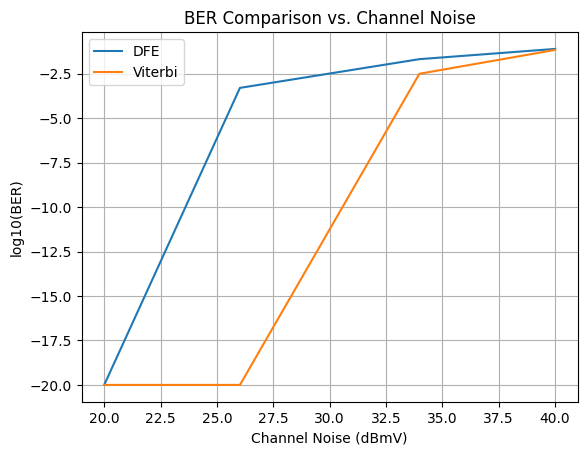

In [6]:
plt.plot(20 * safe_log10(np.array(noise_sigmas) / 1e-3),
         safe_log10(np.array(bit_errs_dfe_noise) / 10_000), label="DFE")
plt.plot(20 * safe_log10(np.array(noise_sigmas) / 1e-3),
         safe_log10(np.array(bit_errs_viterbi_noise) / 10_000), label="Viterbi")
plt.title("BER Comparison vs. Channel Noise")
plt.xlabel("Channel Noise (dBmV)")
plt.ylabel("log10(BER)")
plt.grid()
plt.legend()
plt.show()


Again, we see the Viterbi decoder "hold out" longer before succumbing to the extreme channel noise and rising to meet the DFE at the BER ceiling.

## Performance vs. Ntaps

In this section we evaluate the performance comparison between Viterbi and DFE as a function of the number of taps afforded the DFE.

We'll use the 2.0m (37 dB) channel length, since the 1.75m (33 dB) channel length exhibits no errors, even with only a single DFE tap enabled.
We'll set the noise level to its original minimum value, in order to maximize the relative effect of our choice of number of taps.
And we'll keep the Viterbi trellis depth equal to the number of DFE taps, to get as close as we can to an "apples-to-apples" comparison.

In [7]:
bit_errs_dfe_taps     = []
bit_errs_viterbi_taps = []
n_tapss = [1, 2, 3, 4]
thePyBERT.load_configuration("chnl_2p0.yaml")
thePyBERT.use_agc  = False
thePyBERT.debug    = False
thePyBERT.rn       = 0.005
thePyBERT.pn       = 0.000
thePyBERT.nbits    = 20_000
thePyBERT.eye_bits = 10_000
for tap_tuner in thePyBERT.dfe_tap_tuners:
    tap_tuner.enabled = False
for n_taps in n_tapss:
    thePyBERT.dfe_tap_tuners[n_taps - 1].enabled = True  # Only works if `n_tapss` = [1, 2, 3, ...]!
    thePyBERT.rx_viterbi_symbols = n_taps
    thePyBERT.rx_use_viterbi     = False
    thePyBERT.simulate(initial_run=False)
    bit_errs_dfe_taps.append(thePyBERT.bit_errs)
    thePyBERT.rx_use_viterbi     = True
    thePyBERT.simulate(initial_run=False)
    bit_errs_viterbi_taps.append(thePyBERT.bit_errs)


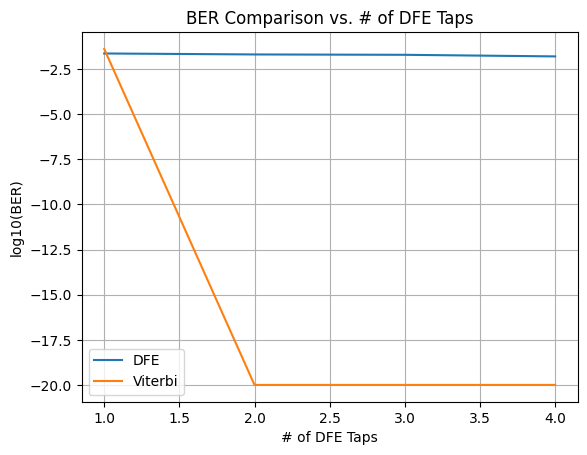

In [8]:
plt.plot(n_tapss, safe_log10(np.array(bit_errs_dfe_taps) / 10_000), label="DFE")
plt.plot(n_tapss, safe_log10(np.array(bit_errs_viterbi_taps) / 10_000), label="Viterbi")
plt.title("BER Comparison vs. # of DFE Taps")
plt.xlabel("# of DFE Taps")
plt.ylabel("log10(BER)")
plt.grid()
plt.legend()
plt.show()


Once again, we find that the Viterbi decoder is a more robust alternative.
We see its BER fall to our measurement floor with a trellis depth of only 2, whereas the DFE is still operating up at the BER ceiling, even with 4 taps enabled!

## Conclusion

From all three perspectives taken, our simulation results reveal the Viterbi decoder to be a more robust solution than the DFE.